# Eyes in the Sky: Predicting Aircraft Damage Caused by Bird Strikes Using Machine Learning
## Part 4: Time Series Analysis

Alan da Silveira Fleck
<br>
alansfleck@gmail.com
<br>
27/09/2021

# Introduction

A time series is a sequential measurement from a system that varies in time. The key difference between a time series analysis and the methods used so far in this project is that it accounts for the fact that data points taken over time may have an internal structure (i.e. autocorrelation, trend or seasonal variation) that should be accounted for [1]. 
<br>
<br>
Considering this difference, the objectives of a time series may be *descriptive* such as to understand the trends and relationships in the observed data, or *forecasting* such as to predict future behavior of the series using past observations [1, 2].
<br>
<br>
Therefore, the objective of Part 4 of this project is to use time series analysis to describe temporal trends and seasonality in bird strikes - thus expanding the insights from the EDA of Part 1 - as well as to build autoregressive models  to forecast future incidents.

# Importing Packages and Reading the Data

The codes below import the relevant packages and read the original data

In [1]:
import numpy as np
import pandas as pd

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.offline as pyo
import matplotlib.pyplot as plt
import seaborn as sns

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

In [2]:
# Reading the csv file into a data frame
bird_time = pd.read_csv('data/bird_strikes.csv', encoding= 'unicode_escape', thousands=',')

# This will show all columns when calling df.head()
pd.set_option("display.max_columns", None)


# Checking the first 5 rows of the dataset
bird_time.head()

Record ID Aircraft: Type                Airport: Name Altitude bin  \
0     202152       Airplane                 LAGUARDIA NY    > 1000 ft   
1     208159       Airplane  DALLAS/FORT WORTH INTL ARPT    < 1000 ft   
2     207601       Airplane            LAKEFRONT AIRPORT    < 1000 ft   
3     215953       Airplane          SEATTLE-TACOMA INTL    < 1000 ft   
4     219878       Airplane                 NORFOLK INTL    < 1000 ft   

  Aircraft: Make/Model Wildlife: Number struck  \
0            B-737-400                Over 100   
1                MD-80                Over 100   
2                C-500                Over 100   
3            B-737-400                Over 100   
4         CL-RJ100/200                Over 100   

   Wildlife: Number Struck Actual Effect: Impact to flight       FlightDate  \
0                             859         Engine Shut Down  2000-11-23 0:00   
1                             424                     None  2001-07-25 0:00   
2                             261                     None  2001-09-14 0:00   
3                             806    Precautionary Landing  2002-09-05 0:00   
4                             942                     None  2003-06-23 0:00   

  Effect: Indicated Damage Aircraft: Number of engines?  \
0            Caused damage                            2   
1            Caused damage                            2   
2                No damage                            2   
3                No damage                            2   
4                No damage                            2   

  Aircraft: Airline/Operator Origin State When: Phase of flight  \
0                US AIRWAYS*     New York                 Climb   
1          AMERICAN AIRLINES        Texas          Landing Roll   
2                   BUSINESS    Louisiana              Approach   
3            ALASKA AIRLINES   Washington                 Climb   
4            COMAIR AIRLINES     Virginia              Approach   

  Conditions: Precipitation  Remains of wildlife collected?  \
0                      None                           False   
1                      None                           False   
2                      None                           False   
3                      None                            True   
4                      None                           False   

   Remains of wildlife sent to Smithsonian  \
0                                    False   
1                                    False   
2                                    False   
3                                    False   
4                                    False   

                                             Remarks Wildlife: Size  \
0  FLT 753. PILOT REPTD A HUNDRED BIRDS ON UNKN T...         Medium   
1  102 CARCASSES FOUND. 1 LDG LIGHT ON NOSE GEAR ...          Small   
2  FLEW UNDER A VERY LARGE FLOCK OF BIRDS OVER AP...          Small   
3  NOTAM WARNING. 26 BIRDS HIT THE A/C, FORCING A...          Small   
4                                      NO DMG REPTD.          Small   

  Conditions: Sky      Wildlife: Species Pilot warned of birds or wildlife?  \
0        No Cloud  Unknown bird - medium                                  N   
1      Some Cloud            Rock pigeon                                  Y   
2        No Cloud      European starling                                  N   
3      Some Cloud      European starling                                  Y   
4        No Cloud      European starling                                  N   

   Cost: Total $  Feet above ground  Number of people injured  \
0          30736               1500                         0   
1              0                  0                         0   
2              0                 50                         0   
3              0                 50                         0   
4              0                 50                         0   

  Is Aircraft Large?  
0                Yes  
1                 No  
2           

# Time Series Data Cleaning & EDA

First, we will convert the `FlightDate` column to date type and set it as the index.

In [3]:
# Transform FlightDate to datetime
bird_time["FlightDate"] = pd.to_datetime(bird_time["FlightDate"])
bird_time = bird_time.set_index("FlightDate")

Now, we will get a count of bird strikes by month for each year. Contrary to the EDA of Part 1 which focused on quarterly patterns, we will explore monthly trends of our data in order to increase the granularity of the analysis.

In [4]:
# tGroup data by month-year. The "MS" option specifies Monthly frequency by Start day
bird_time_monthly = bird_time.resample("MS")['Record ID'].count()

# Convert it back to a data frame
bird_time_monthly = pd.DataFrame(data=bird_time_monthly)

# Rename the count column to 'Counts'
bird_time_monthly.columns = ['Counts']

# View the new data frame
bird_time_monthly.head()

Counts
FlightDate        
2000-01-01      45
2000-02-01      57
2000-03-01      80
2000-04-01     104
2000-05-01     118

Next, we visualize the temporal pattern of the number of bird strikes from 2000 to 2011. The figure below shows almost the same pattern presented in the EDA of Part 1. However temporal changes are now represented by months instead of quarters.
<br>
<br>
As a reminder of the insights from Part 1, the repeated peaks in strikes that extends between July and October may be explained by the bird migration season during the Late Summer/Fall months in North America [3].

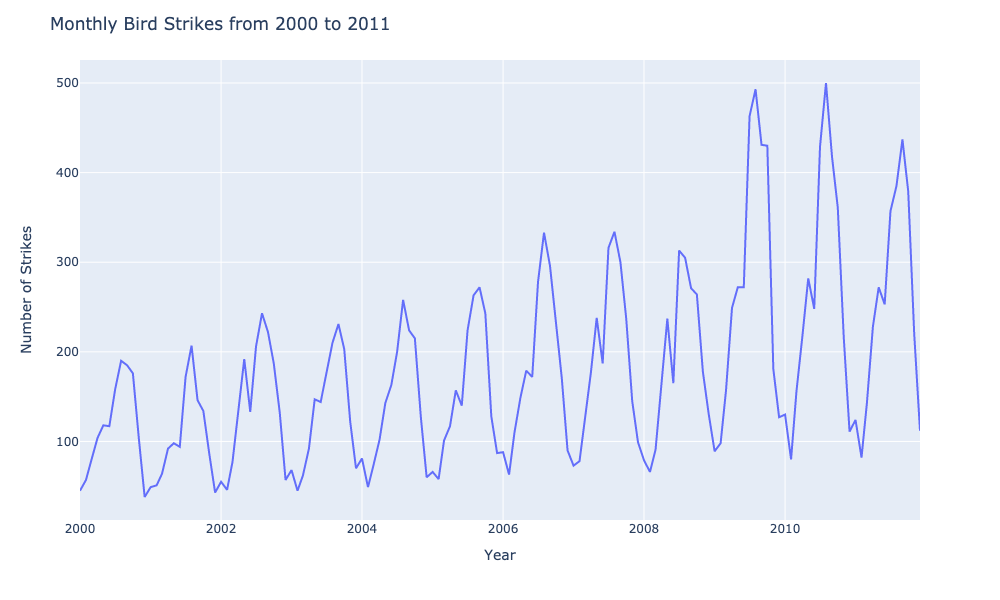

In [5]:
# Set notebook mode to work in offline
pyo.init_notebook_mode()

# Plot the number of strikes over months
fig = px.line(bird_time_monthly, x=bird_time_monthly.index, y="Counts",)
fig.update_layout(
    yaxis_title="Number of Strikes", 
    xaxis_title="Year",
    title="Monthly Bird Strikes from 2000 to 2011"
)

# For an interactive version of the plot, comment out the next line of code and remove the comment from fig.show()
fig.show(renderer = "png", height = 600, width = 1000)
# fig.show()

We can also explore seasonality across multiple years by using a _seasonal plot_, which is implemented in the `statsmodels` package.

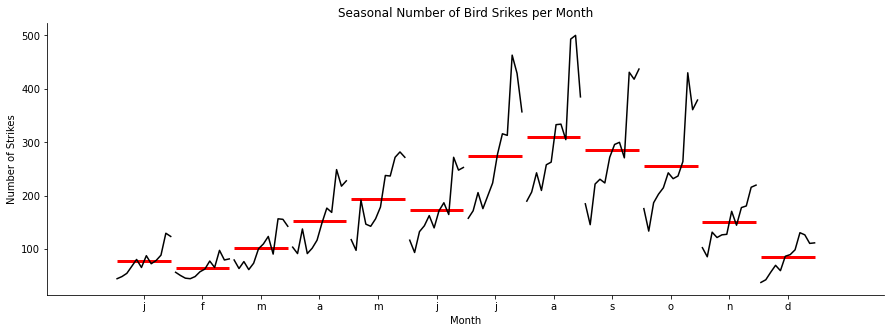

In [6]:
from statsmodels.graphics.tsaplots import month_plot

plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(bird_time_monthly["Counts"], ax=plt.gca())

plt.title("Seasonal Number of Bird Srikes per Month")
plt.xlabel("Month")
plt.ylabel("Number of Strikes")
sns.despine()
plt.show()

The red bars show the average for the given month across all years, while each black line represents an individual month and the progression of values across the years. 
<br>
<br>
We can see a cyclical pattern with an upward trend for each month from January to August - when the number of strikes seemed to peak - and an eventual downtrend again during the last months of the year when the average number of strikes in December seemed to equalize the values from January.

Next, we will calculate the average number of strikes for each month and see how much it differs from the overall average.

In [7]:
# monthly average
# Average for a single time period
monthly_mean = bird_time_monthly.groupby(bird_time_monthly.index.month_name()).mean()

# relative deviation from the overall mean
# Average over a series of time periods. 
monthly_mean_diff = (monthly_mean - monthly_mean.mean())/monthly_mean

# month names in right order
month_names = pd.date_range(start='2000-01', freq='M', periods=12).month_name()

# reorder columns to follow the month order
monthly_mean_diff = monthly_mean_diff.loc[month_names, ]

monthly_mean_diff.T

January  February     March     April       May      June      July  \
Counts -1.249032 -1.755282 -0.718994 -0.160672  0.087866 -0.020035  0.353028   

          August  September   October  November  December  
Counts  0.427618     0.3796  0.304203 -0.177354 -1.077886

And plot these results:

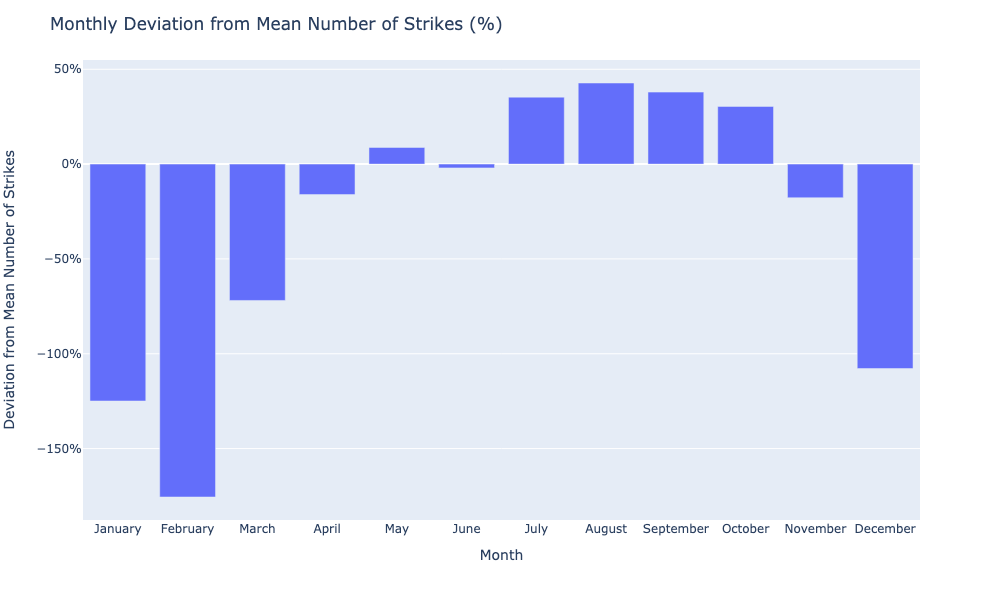

In [8]:
# Plotting the devieation from mean strikes
fig = px.bar(monthly_mean_diff)

fig.update_layout(
    yaxis_tickformat = '%',
    title="Monthly Deviation from Mean Number of Strikes (%)",
    yaxis_title="Deviation from Mean Number of Strikes", 
    xaxis_title="Month",
    showlegend=False,
)

# For an interactive version of the plot, comment out the next line of code and remove the comment from fig.show()
fig.show(renderer = "png", height = 600, width = 1000)
# fig.show()

The figure above illustrates the significant difference between the average number of strikes from December to March compared to the overall mean and the Late Summer/Fall months. This suggests an important influence of the number of strikes between July and October on the overall mean.

# Trend-Seasonal Decomposition 

Next, we will visualize the general trend and seasonality of our data. The following three series from our original observation will be extracted for the trend-seasonal decomposition: 
- a trend component $T_t$ calculated using a moving average,
- a seasonal component $S_t$ which is the monthly/daily average of the de-trended series, and
- the residual $R_t$ that remains after subtracting the trend and seasonal component from the original series.

The original series can be reconstructed by adding up these three components:

$$y_t = T_t + S_t + R_t$$

To do this, we will use the `seasonal_decompose` function from the time series analysis module of `statsmodels`. 

In [9]:
# decompose the time series
decomposition = tsa.seasonal_decompose(bird_time_monthly, model='additive')

In [10]:
# add the decomposition data to the data frame

bird_time_monthly["Trend"] = decomposition.trend
bird_time_monthly["Seasonal"] = decomposition.seasonal
bird_time_monthly["Residual"] = decomposition.resid

bird_time_monthly.head(10)

Counts       Trend    Seasonal   Residual
FlightDate                                           
2000-01-01      45         NaN  -93.185290        NaN
2000-02-01      57         NaN -111.586806        NaN
2000-03-01      80         NaN  -73.007260        NaN
2000-04-01     104         NaN  -22.730745        NaN
2000-05-01     118         NaN   20.238952        NaN
2000-06-01     117         NaN   -2.848169        NaN
2000-07-01     158  114.416667   96.488952 -52.905619
2000-08-01     190  114.333333  132.549558 -56.882891
2000-09-01     185  113.416667  101.307134 -29.723801
2000-10-01     176  112.250000   72.053346  -8.303346

The null values in `Trend` and `Residual` are due to the fact that the trend component is calculated with a rolling average that is not defined at the beginning and end of the series.

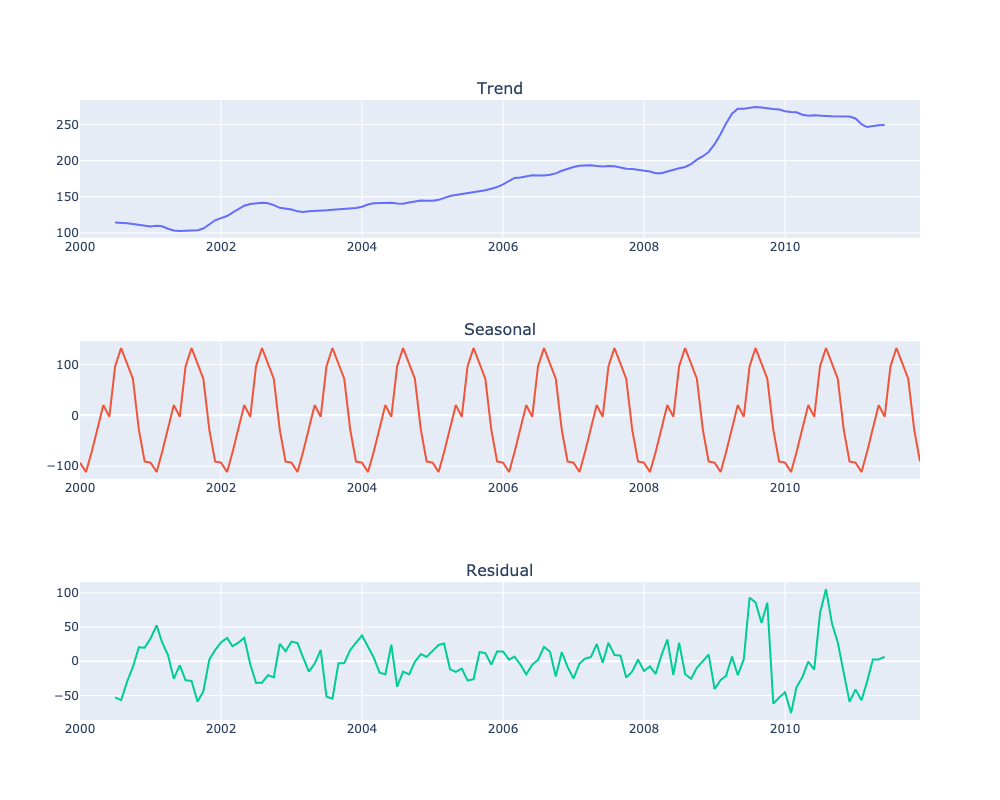

In [34]:
# Visualizing our decomposed data
cols = ["Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=bird_time_monthly.index, y=bird_time_monthly[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=800, width=1000, showlegend=False)

# For an interactive version of the plot, comment out the next line of code and remove the comment from fig.show()
fig.show(renderer = "png", height = 800, width = 1000)
# fig.show()

We can draw the following conclusions from the figure above:

- The `Trend` is clearly upward. We can observe an initial plateaued period between 2000 and 2001, followed by an upward move until 2009 (with a significant increase between 2008 and 2009). After 2009 up until 2011 we can see a second plateau in the trend.
- The `Seasonal` plot shows exactly what we observed using our bar plot for monthly differences.
- Although we can still see a seasonality pattern in the `Residual` (especially at the beginning and end of the plot), we can see that it was mostly captured by the `Seasonal` component.

# Forecasting

One thing to consider before applying forecasting models is how **stationary** is our data. The models applied below, such as SARIMAX and ARIMA, work best on stationary series (i.e. the statistical properties of the series don't change over time). Since our residual after the decomposition does not seem to be stationary (i.e. we still see some remaining seasonality), this is something that needs to be addressed.
<br>
<br>
We will address this issue by transforming the data (i.e. differencing). We will work with the seasonal difference, which is calculated based on the year-over-year change.

In [12]:
# Creating seasonal_difference (i.e. year-over-year change)
bird_time_monthly["seasonal_difference"] = bird_time_monthly["Counts"].diff(12)

The seasonal difference is visualized below:

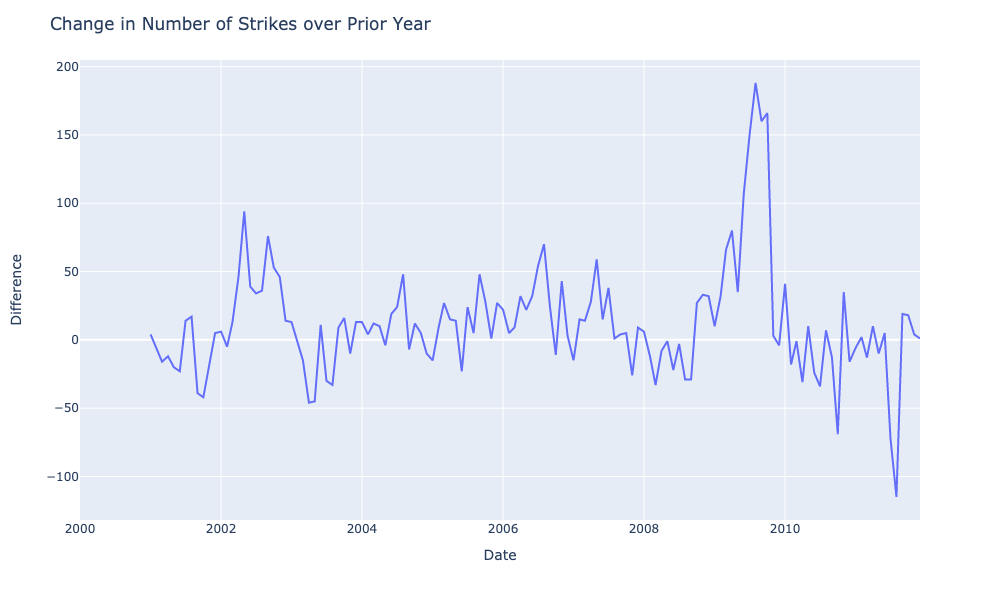

In [13]:
fig = px.line(bird_time_monthly, x=bird_time_monthly.index, y="seasonal_difference")

fig.update_layout(
    yaxis_title="Difference", 
    xaxis_title="Date",
    title="Change in Number of Strikes over Prior Year"
)

# For an interactive version of the plot, comment out the next line of code and remove the comment from fig.show()
fig.show(renderer = "png", height = 600, width = 1000)
# fig.show()

We can see that the data plotted above seems stationary. In other words, there is no clear trend in the new series and also no signs of seasonality.
<br>
<br>
Although our forecasting work will be based on predicting this differenced series instead of the original one, the original series will be restored after.

## Train-test split for time series 

Now, let's perform a train-test split. instead of doing a randomized split like in the models of Part 2 and 3, we will split the data in order to allow the test data to follow the training data in time. This ensures that our models use past observations to infer patterns and trends and are evaluated on records in the relative future. in this context, the threshold defined to split both sets is `December 01, 2009`. in the figure below, we can visualize the Train set in blue and the Test set in red.

In [14]:
# Train-test split. We also drop the null values introduced at differencing
train = bird_time_monthly.loc[bird_time_monthly.index <= "2009-12-01", "seasonal_difference"].dropna()
test = bird_time_monthly.loc[bird_time_monthly.index > "2009-12-01", "seasonal_difference"]

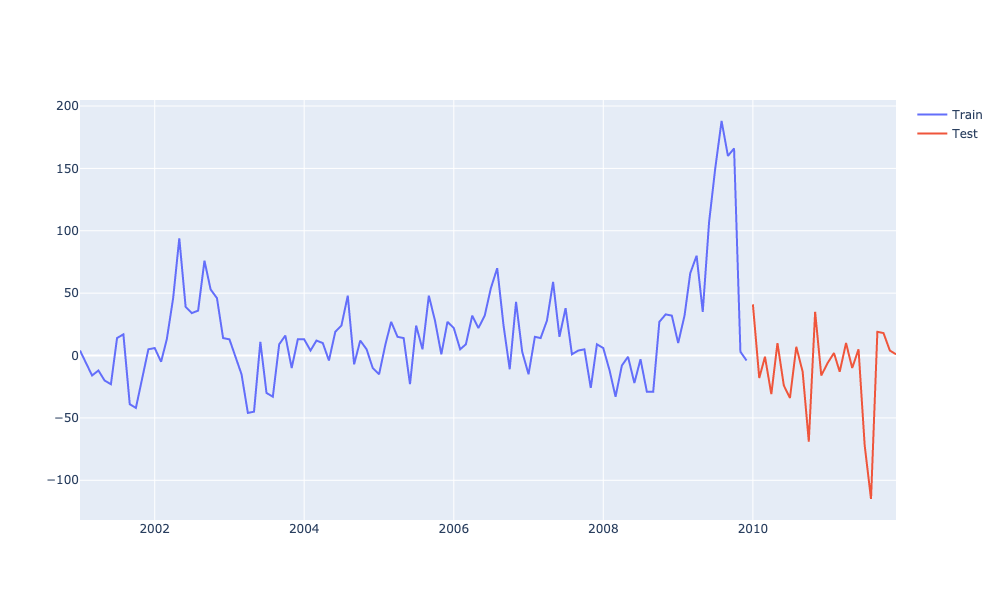

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name="Test"))

# For an interactive version of the plot, comment out the next line of code and remove the comment from fig.show()
fig.show(renderer = "png", height = 600, width = 1000)
# fig.show()

## Baseline Forecast and Evaluation

Next, we will build a baseline model to act as a reference for our forecasting models. This baseline model will be a prediction of the mean over the training set.

In [16]:
# Creating ou baseline prediction based on the mean of the training set
predictions = pd.Series(data=np.full((train.shape[0] + test.shape[0], ), np.mean(train)), index=pd.concat([train, test]).index)

Next, we will plot the mean prediction into our series.

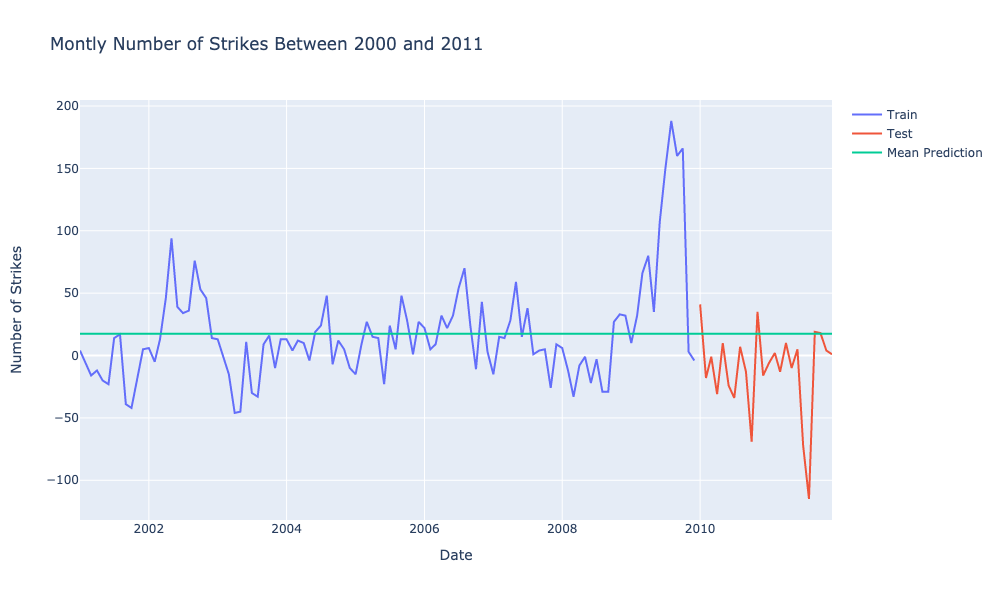

In [17]:
# Plotting the baseline prediction
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', name="Mean Prediction"))

fig.update_layout(
    yaxis_title="Number of Strikes", 
    xaxis_title="Date",
    title="Montly Number of Strikes Between 2000 and 2011"
)

# For an interactive version of the plot, comment out the next line of code and remove the comment from fig.show()
fig.show(renderer = "png", height = 600, width = 1000)
# fig.show()

We will use the _mean absolute percentage error_ (MAPE) in order to compare quantitatively our forecasting models with our baseline model. This metric informs what percentage, on average, our prediction is off by the original value. 

For the baseline model, we see that the MAPEs of the train and test sets are 2.0% and 3.2%, respectively.

In [18]:
from sklearn.metrics import mean_absolute_percentage_error

train_mape = mean_absolute_percentage_error(train, predictions[train.index])
test_mape = mean_absolute_percentage_error(test, predictions[test.index])

print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

Train MAPE on the difference: 2.0%
Test MAPE on the difference: 3.2%


## Autocorrelation and Finding the Order $p$ for Autoregressive (AR) Models

In the next step, we will determine the best value of $p$ to be used in the models. This will be done by identifying which lags are most strongly related to our series values.

For this, we will look at the autocorrelation (i.e. the correlation is between two values of the same variable at times Xi and Xi+k) at different lags (i.e. the number of previous observations measured during autocorrelation). 
<br>
<br>
Below, we can see the autocorrelation plot of our differenced data generated with different lags.

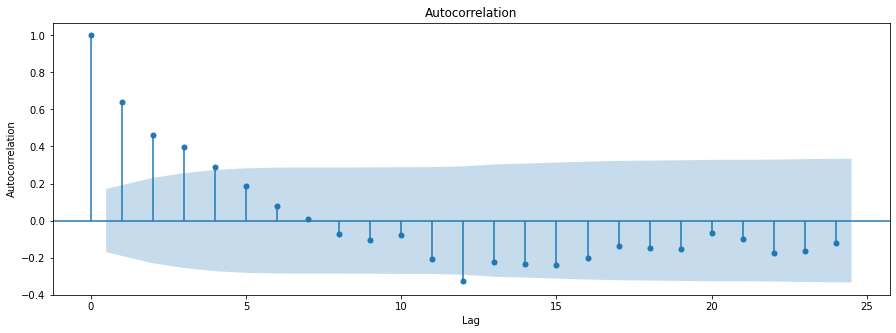

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create the autocorrelation plot
plt.figure(figsize=(15, 5))
plot_acf(bird_time_monthly["seasonal_difference"].dropna(), lags=24, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

The y-axis of the above graph represents the correlation values while the X-axis is the lags of previous values (from 0 to 25 in this case). Thus, the vertical lines correspond to the correlation value at each lag, while the shaded area corresponds to a 95% confidence interval for **non-significant** correlations.

In addition, the _partial autocorrelation_ is the autocorrelation after removing the effect of any correlations resulting from terms at shorter lags. We can get this plot using the _partial autocorrelation function_ (`pacf`) from `statsmodels`.

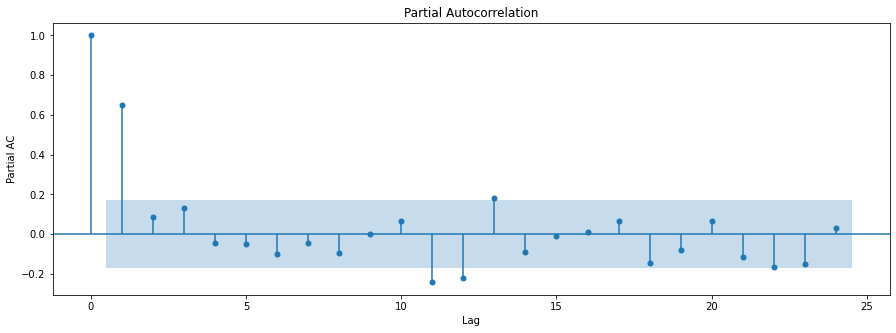

In [20]:
plt.figure(figsize=(15, 5))
plot_pacf(bird_time_monthly["seasonal_difference"].dropna(), lags=24, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

As a rule-of-thumb for picking the right order parameter $p$, we should include all or most of the significant correlations in the PACF plot.

Looking at the above partial autocorrelation plot, we will set the number of lags used as `2`.

Next, we will use the $p$ we just defined to fit a SARIMAX model.

## SARIMAX Model

The `SARIMAX` model takes three main _order_ parameters, the first of which specifies how many lags to use in the AR component. In this case, we will set this parameter to `2` based on the results of our autocorrelation.

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Setting the parameter p
p_param = 2

# Fitting the model
model = SARIMAX(train, order=(p_param, 0, 0), trend="c")
model_fit = model.fit()

# Getting the summary
model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.77717D+00    |proj g|=  5.96627D-03

At iterate    5    f=  4.77710D+00    |proj g|=  1.42573D-03

At iterate   10    f=  4.77703D+00    |proj g|=  1.06773D-04

At iterate   15    f=  4.77702D+00    |proj g|=  1.03223D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   1.656D-06   4.777D+00
  F =   4.7770186168034101     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     seasonal_difference   No. Observations:                  108
Model:                SARIMAX(2, 0, 0)   Log Likelihood                -515.918
Date:                 Mon, 15 Nov 2021   AIC                           1039.836
Time:                         20:14:42   BIC                           1050.565
Sample:                     01-01-2001   HQIC                          1044.186
                          - 12-01-2009                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.8697      3.768      1.292      0.196      -2.516      12.255
ar.L1          0.6955      0.088      7.930      0.000       0.524       0.867
ar.L2          0.0135      0.096      0.141      0.888      -0.174       0.201
sigma2       820.3982     85.364      9.611      0.000     653.089     987.708
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                21.80
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                            -0.14
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The coefficient value of 0.63 for lag-1 tells us that a 1 unit increase in the month prior will drive up the current value by 0.63 giving that all other lags remain the same.

Below, we used the `predict` method to make predictions. To do this, we specified the start and end index for the `predict` method. The predictions will apply the AR formula to the lagged train values as long as they are available. After the last training time step, the forecasted values will be reused in the formula to make the next prediction. 

In [22]:
# Making predictions
predictions = model_fit.predict(start=0, end=len(train)+len(test)-1)

In [23]:
# Visualizing the predicted values
predictions.head()

2001-01-01    16.737831
2001-02-01     7.756731
2001-03-01     0.750538
2001-04-01    -6.340068
2001-05-01    -3.693117
Freq: MS, Name: predicted_mean, dtype: float64

Finally, we can visualize our predictions in the plot below.

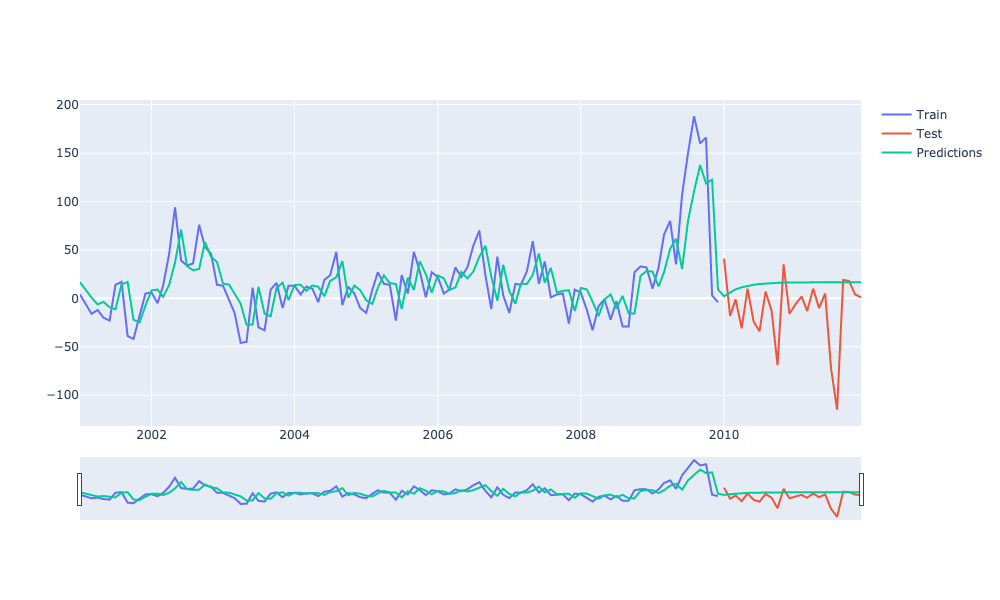

In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)

# For an interactive version of the plot, comment out the next line of code and remove the comment from fig.show()
fig.show(renderer = "png", height = 600, width = 1000)
# fig.show()

The forecast captured the flat trend after 2010, but seemed to overestimate the values.
<br>
Below, we can see how this forecast compares to the baseline model.

In [25]:
# 
train_mape = mean_absolute_percentage_error(train, predictions[train.index])
test_mape = mean_absolute_percentage_error(test, predictions[test.index])

print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

Train MAPE on the difference: 2.18%
Test MAPE on the difference: 2.7%


| Model | Train MAPE | Test MAPE |
| ----- | -------- | ----------- |
| Baseline | 2.0% | 3.2%         |
| SARIMAX | 2.18%| 2.7% |

Our AR model seemed to perform between than the baseline model by reducing the Test MAPE.

## ARIMA Model

Now, we will combine a _Moving Average model_ (MA) with our AR model. We will set three parameters, called $p$, $q$ and $d$. $p$ is determined by our PACF like as defined above. For setting $q$, the original autocorrelation function is more relevant and we will including all components until the last significant correlation. In this case, `3`. The parameter $d$ controls how many times a series is differentiated. Since seasonal differing was already applied, $d$ will be set to `0`.

In [26]:
# Setting the parameters
p_param = 2
d_param = 0
q_param = 3

# Fitting the model
model = SARIMAX(train, order=(p_param, d_param, q_param), trend="c")
model_fit = model.fit()

# Getting the summary
model_fit.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.77783D+00    |proj g|=  9.19775D-03

At iterate    5    f=  4.77760D+00    |proj g|=  4.54966D-03

At iterate   10    f=  4.77390D+00    |proj g|=  9.67022D-03

At iterate   15    f=  4.77372D+00    |proj g|=  8.90279D-04

At iterate   20    f=  4.77360D+00    |proj g|=  4.42398D-03

At iterate   25    f=  4.77354D+00    |proj g|=  1.08331D-03

At iterate   30    f=  4.77327D+00    |proj g|=  2.92367D-03

At iterate   35    f=  4.77324D+00    |proj g|=  1.32090D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     seasonal_difference   No. Observations:                  108
Model:                SARIMAX(2, 0, 3)   Log Likelihood                -515.510
Date:                 Mon, 15 Nov 2021   AIC                           1045.019
Time:                         20:14:42   BIC                           1063.794
Sample:                     01-01-2001   HQIC                          1052.632
                          - 12-01-2009                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.3482      7.668      0.958      0.338      -7.680      22.376
ar.L1         -0.0178      0.593     -0.030      0.976      -1.180       1.144
ar.L2          0.5822      0.410      1.419      0.156      -0.222       1.386
ma.L1          0.7315      0.614      1.191      0.234      -0.472       1.935
ma.L2         -0.0733      0.287     -0.255      0.798      -0.636       0.489
ma.L3         -0.1087      0.208     -0.522      0.601      -0.517       0.299
sigma2       813.7892    104.895      7.758      0.000     608.198    1019.380
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.94
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.37   Skew:                            -0.14
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's check the predictions.

In [27]:
# Making the predictions
predictions = model_fit.predict(start=0, end=len(train)+len(test)-1)

# Calculating the MAPE
train_mape = mean_absolute_percentage_error(train, predictions[train.index])
test_mape = mean_absolute_percentage_error(test, predictions[test.index])

# Printing the results
print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

Train MAPE on the difference: 2.23%
Test MAPE on the difference: 2.79%


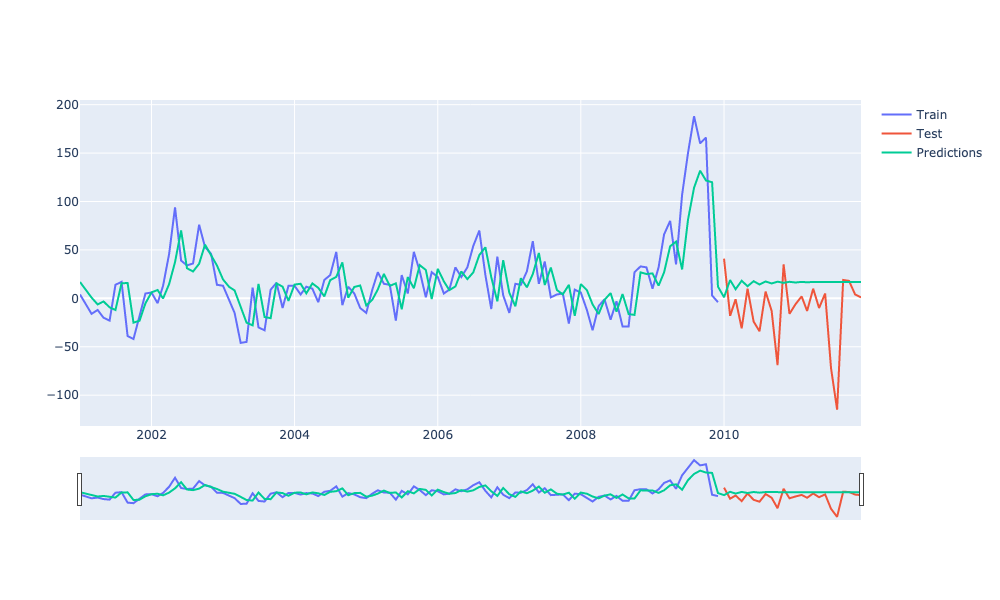

In [28]:
# Plotting the predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)

# For an interactive version of the plot, comment out the next line of code and remove the comment from fig.show()
fig.show(renderer = "png", height = 600, width = 1000)
# fig.show()


Similar to the SARIMAX model, the ARIMA model forecast also captured the flat trend after 2010, but seemed to overestimate the values in the Test set. Overall, however, this model also resulted in a lower Test MAPE compared to the baseline model. This indicates that both forecast models tested here performed better than predicting a mean value.

| Model | Train MAPE | Test MAPE |
| ----- | -------- | ----------- |
| Baseline | 2.0% | 3.2%         |
| SARIMAX | 2.18%| 2.7% |
| ARIMA | 2.23%| 2.79% |

### Reconstructing the Original Series

Finally, we will translate our predictions to the original time series. In order to reconstruct the number of bird strikes from the seasonal difference, we start with the original 12 values and always looking back 12 months, we add the difference to get the next restored value, as follows:

In [29]:
first_date = bird_time_monthly.index.min()

# create an empty restored column
bird_time_monthly["restored"] = np.nan

# fill in the first 12 original values
bird_time_monthly.loc[first_date: first_date + pd.DateOffset(months=11), "restored"] = \
    bird_time_monthly.loc[first_date: first_date + pd.DateOffset(months=11), "Counts"]

# use the current difference and 12-month lagged restored value to get the next restored
for date, val in bird_time_monthly.loc[first_date + pd.DateOffset(months=12):, "seasonal_difference"].items():
    bird_time_monthly.loc[date, "restored"] = bird_time_monthly.loc[date - pd.DateOffset(months=12), "restored"] + val

# check agreement everywhere (rounding errors can come up so check closeness rather than strict equality)
np.allclose(bird_time_monthly["Counts"], bird_time_monthly["restored"])

True

Repeating this process for the AR prediction starting at the test set.

In [30]:
# use the original train diff values and predicted test values
bird_time_monthly.loc[train.index, "AR_difference"] = bird_time_monthly.loc[train.index, "seasonal_difference"]
bird_time_monthly.loc[test.index, "AR_difference"] = predictions[test.index]

# empty restored column
bird_time_monthly["AR_restored"] = np.nan

# fill in the first 12 original values
bird_time_monthly.loc[first_date: first_date + pd.DateOffset(months=11), "AR_restored"] = \
    bird_time_monthly.loc[first_date: first_date + pd.DateOffset(months=11), "Counts"]

# use the current difference and 12-month lagged restored value to get the next restored
for date, val in bird_time_monthly.loc[first_date + pd.DateOffset(months=12):, "AR_difference"].items():
    bird_time_monthly.loc[date, "AR_restored"] = \
        bird_time_monthly.loc[date - pd.DateOffset(months=12), "AR_restored"] + val

In [31]:
# Checking the restored data
bird_time_monthly.head(14)

Counts       Trend    Seasonal   Residual  seasonal_difference  \
FlightDate                                                                   
2000-01-01      45         NaN  -93.185290        NaN                  NaN   
2000-02-01      57         NaN -111.586806        NaN                  NaN   
2000-03-01      80         NaN  -73.007260        NaN                  NaN   
2000-04-01     104         NaN  -22.730745        NaN                  NaN   
2000-05-01     118         NaN   20.238952        NaN                  NaN   
2000-06-01     117         NaN   -2.848169        NaN                  NaN   
2000-07-01     158  114.416667   96.488952 -52.905619                  NaN   
2000-08-01     190  114.333333  132.549558 -56.882891                  NaN   
2000-09-01     185  113.416667  101.307134 -29.723801                  NaN   
2000-10-01     176  112.250000   72.053346  -8.303346                  NaN   
2000-11-01     103  110.916667  -28.363321  20.446654                  NaN   
2000-12-01      38  109.125000  -90.916351  19.791351                  NaN   
2001-01-01      49  108.750000  -93.185290  33.435290                  4.0   
2001-02-01      51  110.041667 -111.586806  52.545139                 -6.0   

            restored  AR_difference  AR_restored  
FlightDate                                        
2000-01-01      45.0            NaN         45.0  
2000-02-01      57.0            NaN         57.0  
2000-03-01      80.0            NaN         80.0  
2000-04-01     104.0            NaN        104.0  
2000-05-01     118.0            NaN        118.0  
2000-06-01     117.0            NaN        117.0  
2000-07-01     158.0            NaN        158.0  
2000-08-01     190.0            NaN        190.0  
2000-09-01     185.0            NaN        185.0  
2000-10-01     176.0            NaN        176.0  
2000-11-01     103.0            NaN        103.0  
2000-12-01      38.0            NaN         38.0  
2001-01-01      49.0            4.0         49.0  
2001-02-01      51.0           -6.0         51.0

Finally, we can plot our restored AR with our original time series.

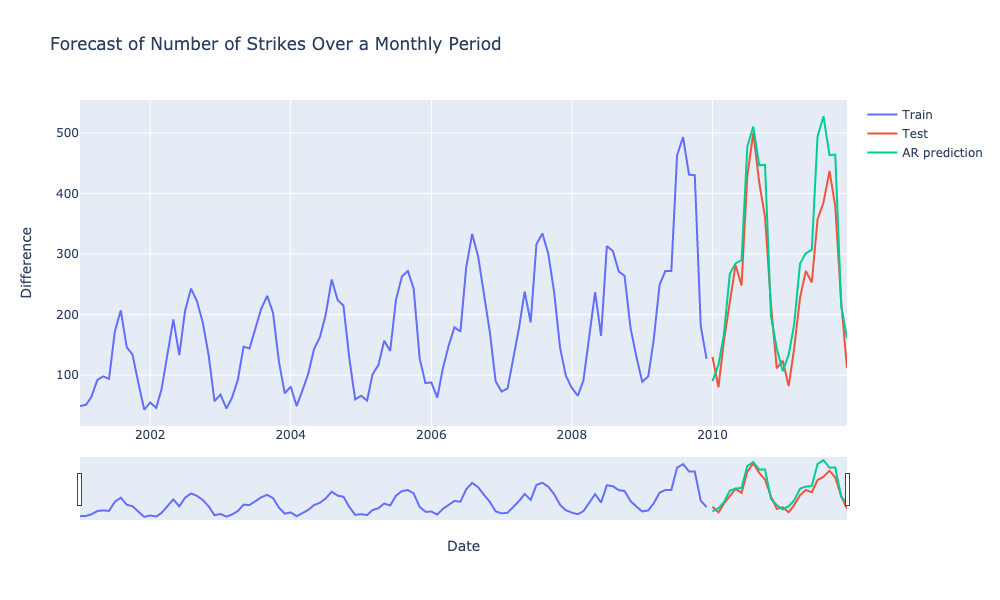

In [32]:
# Plotting the predictions in the original data.
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=bird_time_monthly.loc[train.index, "Counts"], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=bird_time_monthly.loc[test.index, "Counts"], mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=test.index, y=bird_time_monthly.loc[test.index, "AR_restored"], mode='lines', name="AR prediction"))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Difference", 
    xaxis_title="Date",
    title=" Forecast of Number of Strikes Over a Monthly Period"
)

# For an interactive version of the plot, comment out the next line of code and remove the comment from fig.show()
fig.show(renderer = "png", height = 600, width = 1000)
# fig.show()

As seen in the figure above, and also discussed for the seasonal difference forecasts, our model seems to accurately predict the trend and capture the monthly patterns almost perfectly. However, we can see an overestimation in the predicted number of strikes, especially for the data between February 2011 and December 2011. Our model predicted a continuation of the increasing trend in the number of strikes in 2011 when, in reality, we observed a smaller peak for this year.

# Conclusions

The analyses performed here lead to the following conclusions:

- The number of bird strikes over the years follows a seasonal pattern with higher averages for July, August, September and October. These months correspond to the bird migration period in North America.
- The number of strikes increased from 2000 to 2011, as suggested by the positive trend in the series. The continuation of this trend may lead to an increased number of damaging incidents in the future.
- The forecasting model correctly captured the seasonal pattern of the data and may be used to predict future strikes, as well as to guide plans of action in a monthly time frame.
- Future analyses should focus on data before and after the pandemic in order to capture the patterns that emerged from the disruptions in the aviation industry during this period.

# References

[1] NIST/SEMATECH e-Handbook of Statistical Methods, http://www.itl.nist.gov/div898/handbook/. Accessed of September 23, 2021.
<br>
[2] Shumway RH, Stoffer DS, Stoffer DS. Time series analysis and its applications. New York: Springer; 2000 Mar.
<br>
[3] Federal Aviation Administration. Wildlife Hazard Mitigation. https://www.faa.gov/airports/airport_safety/wildlife/faq/. Accessed on September 19, 2021.